In [10]:
# packages

import pathlib
import numpy as np
import math as m
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import scipy.integrate as integrate
from scipy import signal
from scipy.optimize import fsolve
from scipy.interpolate import interp2d
from sympy import symbols, Eq, solve, I, cos, exp, pi
import os
os.chdir(os.path.abspath(''))


In [11]:
# functions

def compute_transform_matrices(theta_blade, theta_yaw, theta_tilt, theta_cone):

    a1 = (  [1,0,0],
            [0, np.cos(theta_yaw), np.sin(theta_yaw)],
            [0, -np.sin(theta_yaw), np.cos(theta_yaw)])
    a2 = (  [np.cos(theta_tilt), 0, -np.sin(theta_tilt)],
            [0, 1, 0],
            [np.sin(theta_tilt), 0, np.cos(theta_tilt)])
    a12 = np.matmul(a2, a1)
    a21 = np.transpose(a12)
    
    a23 = ( [np.cos(theta_blade), np.sin(theta_blade), 0],
            [-np.sin(theta_blade), np.cos(theta_blade), 0],
            [0, 0, 1])
    a34 = ( [np.cos(theta_cone), 0, -np.sin(theta_cone)],
            [0, 1, 0],
            [np.sin(theta_cone), 0, np.cos(theta_cone)])
    
    a14 = np.matmul(np.matmul(a34,a23), a12)
    a41 = np.transpose(a14)

    return a21, a23, a41 

def compute_position(a21, a41, H, Ls, radius):
    
    rt = np.transpose([H,0,0])
    rs = np.matmul(a21, np.transpose([0,0,-Ls]))
    rb = np.matmul(a41, np.transpose([radius,0,0]))
    position = rt + rs + rb
    
    return position

def compute_tower_radius(x):

    if x <= H:
        a = a0
    else:
        a = 0
    
    return a


# interpolate airfoil (provided in course materials)

files=[ 'FFA-W3-241.txt',
        'FFA-W3-301.txt',
        'FFA-W3-360.txt',
        'FFA-W3-480.txt',
        'FFA-W3-600.txt',
        'cylinder.txt']

#Initializing tables    
cl_tab=np.zeros([105,6])
cd_tab=np.zeros([105,6])
cm_tab=np.zeros([105,6])
aoa_tab=np.zeros([105,])
fstat_tab=np.zeros([105,6])
Cl_inv_tab=np.zeros([105,6])
Cl_fs_tab=np.zeros([105,6])

#Reading of tables. Only do this once at startup of simulation
for i in range(np.size(files)):
    aoa_tab[:],cl_tab[:,i],cd_tab[:,i],cm_tab[:,i],fstat_tab[:,i],Cl_inv_tab[:,i],Cl_fs_tab[:,i] = np.loadtxt(files[i], skiprows=0).T

thick_prof=np.zeros(6)
thick_prof[0]=24.1
thick_prof[1]=30.1
thick_prof[2]=36
thick_prof[3]=48
thick_prof[4]=60
thick_prof[5]=100

def force_coeffs_10MW(angle_of_attack,thick,aoa_tab,cl_tab,cd_tab,cm_tab,fstat_tab, Cl_inv_tab,Cl_fs_tab):
    
    cl_aoa=np.zeros([1,6])
    cd_aoa=np.zeros([1,6])
    cm_aoa=np.zeros([1,6])
    fstat_aoa=np.zeros([1,6])
    Cl_inv_aoa=np.zeros([1,6])
    Cl_fs_aoa=np.zeros([1,6])
    
    #Interpolate to current angle of attack:
    for i in range(np.size(files)):
        cl_aoa[0,i]=np.interp (angle_of_attack,aoa_tab,cl_tab[:,i])
        cd_aoa[0,i]=np.interp (angle_of_attack,aoa_tab,cd_tab[:,i])
        cm_aoa[0,i]=np.interp (angle_of_attack,aoa_tab,cm_tab[:,i])
        fstat_aoa[0,i]=np.interp (angle_of_attack,aoa_tab,fstat_tab[:,i])
        Cl_inv_aoa[0,i]=np.interp (angle_of_attack,aoa_tab,Cl_inv_tab[:,i])
        Cl_fs_aoa[0,i]=np.interp (angle_of_attack,aoa_tab,Cl_fs_tab[:,i])
    
    #Interpolate to current thickness:
    cl=np.interp (thick,thick_prof,cl_aoa[0,:])
    cd=np.interp (thick,thick_prof,cd_aoa[0,:])
    cm=np.interp (thick,thick_prof,cm_aoa[0,:])
    fstat=np.interp (thick,thick_prof,fstat_aoa[0,:])
    cl_inv=np.interp (thick,thick_prof,Cl_inv_aoa[0,:])
    cl_fs=np.interp (thick,thick_prof,Cl_fs_aoa[0,:])

    return cl, cd, cm , fstat, cl_inv, cl_fs



# BEM

def aeroelasticity(t_total=10, dt=0.1, V0=10, turb=False, theta_pitch=0, omega=1):
    num = int(t_total / dt)+1 # number of time steps

    # creating empty arrays to store values
    time = np.zeros(num)
    
    P = np.zeros((num,B))
    T = np.zeros((num,B))
    
    Wy = np.zeros((B,len(r_array)))
    Wz = np.zeros((B,len(r_array)))

    Wy_int = np.zeros((B,len(r_array)))
    Wz_int = np.zeros((B,len(r_array)))

    Wy_qs = np.zeros((B,len(r_array)))
    Wz_qs = np.zeros((B,len(r_array)))

    fs_matrix = np.zeros((B,len(r_array)))

    theta_pitch_array = np.zeros(num)
    omega_array = np.zeros(num)

    x_array = np.zeros((num,B,3))
    dx_array = np.zeros((num,B,3))
    ddx_array = np.zeros((num,B,3))

    GF_array = np.zeros((num,B,3))

    u_array = np.zeros((num,B,len(r_array),2))
    du_array = np.zeros((num,B,len(r_array),2))
    ddu_array = np.zeros((num,B,len(r_array),2))


    # initial conditions
    theta_blade1_old = 0 # initial position of blade 1 [rad]
    theta_I = theta_pitch # initial integral term of controller
    
    ddx = np.linalg.inv(M_matrix) @ (GF_array[0,0,:] - C_matrix@dx_array[0,0,:] - K_matrix@x_array[0,0,:])


    # time step iteration
    for n in range(num):

        # simulation time [s]
        time[n] = n*dt

        '''
        ##########       BEM       ##########
        '''

        # blade positions [rad]
        theta_blade1 = theta_blade1_old + omega*dt
        theta_blade2 = theta_blade1 + 2*np.pi/B
        theta_blade3 = theta_blade2 + 2*np.pi/B

        theta_blade_array = [theta_blade1, theta_blade2, theta_blade3]

        # empty arrays for storing P and T for all blades in current time step
        P_inst = np.zeros(B)
        T_inst = np.zeros(B)

        py_array = np.zeros((B,len(r_array)))
        pz_array = np.zeros((B,len(r_array)))


        # blades iteration
        for j in range(B):

            # calculate transformation matrices for current blade position
            a21, a23, a41 = compute_transform_matrices(theta_blade_array[j], theta_yaw, theta_tilt, theta_cone)

            # empty arrays for storing dP, dT for each segment
            dP_array = np.zeros(len(r_array))
            dT_array = np.zeros(len(r_array))

            
            # blade segment iteration
            for i in range(len(r_array)):
                # parameters of the segment
                r = r_array[i] # radius [m]
                beta = beta_array[i] # twist angle [rad]
                c = c_array[i] # chord length [m]
                thick_perc = t_perc_array[i] # thickness ratio of blade [%]
                
                # segment position in CS1
                r_1_vec = compute_position(a21, a41, H, Ls, r)

                # wind speed of segment based on wind shear
                V0x = V0*(r_1_vec[0] / H)**nu

                # tower model calculations
                y = r_1_vec[1]
                z = r_1_vec[2]
                r_1 = np.sqrt(y**2 + z**2)
                a_tower = compute_tower_radius(r_1_vec[0]) # tower radius at current height [m]

                Vr =     z/r_1 * V0x * (1 - (a_tower/r_1)**2)
                Vtheta = y/r_1 * V0x * (1 + (a_tower/r_1)**2)

                if turb == True:
                    # calculating the fluctuating component (interpolation)
                    f_u = interp2d(y_sample, x_sample, fluc_x[n])
                    f_v = interp2d(y_sample, x_sample, fluc_y[n])
                    f_w = interp2d(y_sample, x_sample, fluc_z[n])

                    # final wind components in CS1 [m/s]
                    Vx = float(0 + f_u(y, z))
                    Vy = float(y/r_1 * Vr - z/r_1 * Vtheta + f_v(y, z))
                    Vz = float(z/r_1 * Vr + y/r_1 * Vtheta + f_w(y, z))
                else:
                    # final wind components in CS1 [m/s]
                    Vx = 0
                    Vy = y/r_1 * Vr - z/r_1 * Vtheta
                    Vz = z/r_1 * Vr + y/r_1 * Vtheta

                # total velocity
                a14 = np.transpose(a41)
                V0_1 = [Vx, Vy, Vz] # wind speed in CS1 [m/s]
                V0_4 = np.matmul(a14, np.transpose(V0_1)) # wind speed in CS4 [m/s]
                V0_magn = np.linalg.norm(V0_4) # magnitude of local wind considering wind shear and tower effect
                
                # relative wind speeds (CS4) [m/s]
                Vrel_y = V0_4[1] + Wy[j,i] - omega*r*np.cos(theta_cone) # tangential
                Vrel_z = V0_4[2] + Wz[j,i] # normal
                Vrel = np.sqrt(Vrel_y**2 + Vrel_z**2) # magnitude

                phi = np.arctan(- Vrel_z/Vrel_y) # flow angle [rad]
                alpha = phi - (beta + theta_pitch) # angle of attack [rad]

                # lift and drag coefficients
                fs_old = fs_matrix[j,i]
                Cl, Cd, Cm, fstat, Cl_inv, Cl_fs = force_coeffs_10MW(np.rad2deg(alpha),thick_perc,aoa_tab,cl_tab,cd_tab,cm_tab,fstat_tab, Cl_inv_tab,Cl_fs_tab)
                tau = 4 * c / Vrel
                fs = fstat + (fs_old - fstat) * np.exp(-dt/tau)
                Cl = fs * Cl_inv + (1-fs) * Cl_fs

                fs_matrix[j,i] = fs
                
                # induction factor and Glauert correction
                a = - Wz[j,i] / V0            # check what happens with V0_local => is a too much spiky?
                if a <= 1/3:
                    fg = 1
                else:
                    fg = 1/4* (5-3*a)
                
                # Prandtl tip loss correction
                F = 2/np.pi * np.arccos(np.exp(-B/2 * (R-r)/(r*np.sin(np.abs(phi)))))

                # lift and drag forces [N/m]
                l = 0.5*rho*Vrel**2 * c * Cl # lift
                d = 0.5*rho*Vrel**2 * c * Cd # drag

                # normal and tangential loads [N/m]
                pz = l*np.cos(phi) + d*np.sin(phi) # normal
                py = l*np.sin(phi) - d*np.cos(phi) # tangential

                # quasi-steady induced wind
                Wy_qs_new = (- B * l * np.sin(phi)) / (4*np.pi * rho * r * F * np.sqrt(V0_4[1]**2 + (V0_4[2] + fg*Wz[j,i])**2))
                Wz_qs_new = (- B * l * np.cos(phi)) / (4*np.pi * rho * r * F * np.sqrt(V0_4[1]**2 + (V0_4[2] + fg*Wz[j,i])**2))

                # updating induced wind
                k = 0.6
                tau_1 = 1.1/(1-1.3*a) * R/V0  #time constant 1
                tau_2 = (0.39-0.26 * (r/R)**2) * tau_1 #time constant 2

                RHS_y = Wy_qs_new + k * tau_1 * (Wy_qs_new - Wy_qs[j,i]) / dt
                Wy_int[j,i] = RHS_y + (Wy_int[j,i] - RHS_y) * np.exp(-dt/tau_1)
                Wy[j,i] = Wy_int[j,i] + (Wy[j,i] - Wy_int[j,i]) * np.exp(-dt/tau_2)
                # Wy[j,i] = Wy_qs_new  # killing the dynamic wake model for faster convergence

                RHS_z = Wz_qs_new + k * tau_1 * (Wz_qs_new - Wz_qs[j,i]) / dt
                Wz_int[j,i] = RHS_z + (Wz_int[j,i] - RHS_z) * np.exp(-dt/tau_1)
                Wz[j,i] = Wz_int[j,i] + (Wz[j,i] - Wz_int[j,i]) * np.exp(-dt/tau_2)
                # Wz[j,i] = Wz_qs_new  # killing the dynamic wake model for faster convergence
                
                Wy_qs[j,i] = Wy_qs_new
                Wz_qs[j,i] = Wz_qs_new

                # power and thrust of segment
                dP = omega*py*r # power
                dT = pz # thrust

                dP_array[i] = dP
                dT_array[i] = dT

                py_array[j,i] = py
                pz_array[j,i] = pz

            # integrating segment values to get P and T per blade
            P_blade = integrate.simpson(y=dP_array, x=r_array)
            T_blade = integrate.simpson(y=dT_array, x=r_array)
            
            P_inst[j] = P_blade
            T_inst[j] = T_blade

        # updating blade location
        theta_blade1_old = theta_blade1

        P[n,:] = P_inst
        T[n,:] = T_inst


        '''
        ########## CONTROL ##########
        '''

        GK = 1/(1+theta_pitch/K1)
        theta_P = GK * Kp * (omega - omega_ref)
        theta_I = theta_I +  GK * Ki * (omega - omega_ref) * dt
        theta_sp = theta_P + theta_I
        
        if theta_sp > theta_pitch + dtheta_pitch * dt:
            theta_sp = theta_pitch + dtheta_pitch * dt
        elif theta_sp < theta_pitch - dtheta_pitch * dt:
            theta_sp = theta_pitch - dtheta_pitch * dt

        if theta_sp > theta_pitch_max:
            theta_sp = theta_pitch_max
        elif theta_sp < theta_pitch_min:
            theta_sp = theta_pitch_min

        theta_pitch = theta_sp
        M_aero = sum(P[-1])/omega

        if omega > omega_rated:
            M_g = P_rated / omega_rated
        else:
            M_g = K * omega**2
        omega = omega + (M_aero - M_g)/I * dt

        omega_array[n] = omega
        theta_pitch_array[n] = theta_pitch

        
        '''
        ########## STRUCTURAL ##########
        '''

        # prediction
        ddx_up = ddx
        dx_up = dx_array[n-1,0,:] + dt*ddx
        x_up = x_array[n-1,0,:] + dt*dx_array[n-1,0,:] + 0.5*dt**2 * ddx

        GF1 = integrate.simpson(y=py_array[0,:]*u1fy_array, x=r_array) + integrate.simpson(y=pz_array[0,:]*u1fz_array, x=r_array)
        GF2 = integrate.simpson(y=py_array[0,:]*u1ey_array, x=r_array) + integrate.simpson(y=pz_array[0,:]*u1ez_array, x=r_array)
        GF3 = integrate.simpson(y=py_array[0,:]*u2fy_array, x=r_array) + integrate.simpson(y=pz_array[0,:]*u2fz_array, x=r_array)
        GF = np.array([GF1, GF2, GF3])
        GF_array[n,0,:] = GF

        check = 0
        step = 0

        while check==0:

            # step 3
            residual = GF - M_matrix@ddx_up - C_matrix@dx_up - K_matrix@x_up
            r_max = np.max(np.abs(residual))
            print("r_max is ",r_max)

            # step 4
            K_eff = K_matrix + (gamma / (beta*dt))*C_matrix + (1/(beta*dt**2))*M_matrix
            delta_x = np.linalg.inv(K_eff) @ residual
            
            x_up = x_up + delta_x
            dx_up  = dx_up + (gamma/(beta*dt))*delta_x
            ddx_up = ddx_up + (1/(beta*dt**2))*delta_x

            step += 1
            if r_max < eps:
                check = 1
                print(f'condition reached at {step} steps')
            if step > step_max:
                check = 1
                print('max cunt reached')
        
        ddx_array[n,0,:] = ddx_up
        dx_array[n,0,:] = dx_up
        x_array[n,0,:] = x_up

        for i in range(len(r_array)):
            u_array[n,0,i,:] = x_up[0]*u1f_array[i,:] + x_up[1]*u1e_array[i,:] + x_up[2]*u2f_array[i,:]
            

    solution = {
    'time': time,
    'P': P,
    'T': T,
    'pt': py_array,
    'pn': pz_array,
    'omega': omega_array,
    'theta_pitch': theta_pitch_array,
    "x_array": x_array,
    "dx_array": dx_array,
    "ddx_array": ddx_array,
    "GF_array": GF_array,
    "u_array": u_array,
    "du_array": du_array,
    "ddu_array": ddu_array
    }

    return solution


def load(filename, N=(32, 32)):

    data = np.fromfile(filename, np.dtype('<f'), -1)
    if len(N) == 2:
        ny, nz = N
        nx = len(data) / (ny * nz)
        assert nx == int(nx), "Size of turbulence box (%d) does not match ny x nz (%d), nx=%.2f" % (
            len(data), ny * nz, nx)
        nx = int(nx)
    else:
        nx, ny, nz = N
        assert len(data) == nx * ny * \
            nz, "Size of turbulence box (%d) does not match nx x ny x nz (%d)" % (len(data), nx * ny * nz)
    return data.reshape(nx, ny * nz)


In [12]:
# READ DATA

# blade geometry
blade = pd.read_csv('bladedat.txt',delimiter='\t',header=None,names=['r','beta','c','t_perc'])
r_array = blade['r'] # radius [m]
beta_array = np.deg2rad(blade['beta']) # twist angle [rad]
c_array = blade['c'] # chord length [m]
t_perc_array = blade['t_perc'] # thickness ratio [%]

# mode shapes
modeshape = pd.read_csv('modeshapes.txt',delim_whitespace=True,header=2,names=['r', 'u1fy','u1fz','u1ey','u1ez', 'u2fy', 'u2fz', 'm'])
new_row = pd.DataFrame({'r': [2.8000], 'u1fy': [0], 'u1fz': [0], 'u1ey': [0], 'u1ez': [0], 'u2fy': [0], 'u2fz': [0], 'm': [1189.51],}) 
modeshape = pd.concat([new_row, modeshape]).reset_index(drop=True)

u1fy_array = modeshape['u1fy']
u1fz_array = modeshape['u1fz']
u1ey_array = modeshape['u1ey']
u1ez_array = modeshape['u1ez']
u2fy_array = modeshape['u2fy']
u2fz_array = modeshape['u2fz']
m_array = modeshape['m']

u1f_array = np.array([u1fy_array, u1fz_array]).T
u1e_array = np.array([u1ey_array, u1ez_array]).T
u2f_array = np.array([u2fy_array, u2fz_array]).T

omega1f=3.93
omega1e=6.10
omega2f=11.28

C:\Users\s232055\AppData\Local\Temp\ipykernel_21664\2792674225.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  modeshape = pd.read_csv('modeshapes.txt',delim_whitespace=True,header=2,names=['r', 'u1fy','u1fz','u1ey','u1ez', 'u2fy', 'u2fz', 'm'])


In [13]:
# DATA GLOBAL

# TIME SIMULATION PARAMETERS
t_total = 60
dt = 0.1 # time step size [s]
num = int(t_total / dt)+1 # number of time steps

# NEWMARK COVERGENCE PARAMETERS
eps = 1e-3
step_max = 600


# GEOMETRICAL PARAMETERS
B = 3 # number of blades
R = 89.17 # rotor diameter [m]
H = 119 # hub height [m]
Ls = 7.1 # length of nacelle [m]
a0 = 0 # tower radius [m] 

rho = 1.225 # air density [kg/m3]

#r_target = 65.75 # radius of the interesting blade segment [m]
#id_target = 9 # index of the interesting blade segment

# wind
nu = 0.0 # wind shear exponent
V0 = 8 # mean wind speed at hub height [m/s]

# angles
theta_yaw = np.deg2rad(0) # yaw angle [rad]
theta_tilt = np.deg2rad(0) # tilt angle [rad]
theta_cone = np.deg2rad(0) # cone angle [rad]


# CONTROL
Ki = 0.64 #radians
Kp = 1.5 #radians
K1 = np.deg2rad(14)
I = 1.6e8
theta_pitch_min = 0
theta_pitch_max = np.deg2rad(45)
dtheta_pitch = np.deg2rad(9) #rad/s
omega_rated = 1.02265
omega_ref = 1.01 * omega_rated
P_rated = 10.64e6
lam = 8
c_P = 0.4662 #c_p optimal
K = 0.5 * rho * np.pi*R**2 * R**3 * c_P/lam**3
V_rated = (R*omega_rated)/lam


# STRUCTURAL
k_spring = 1.7e8
mass = 446e3
delta = 0.03
beta = 0.25
gamma = 0.5

GM1 = integrate.simpson(y=u1fy_array**2 * m_array , x=r_array) + integrate.simpson(y=u1fz_array**2 * m_array , x=r_array)
GM2 = integrate.simpson(y=u1ey_array**2 * m_array , x=r_array) + integrate.simpson(y=u1ez_array**2 * m_array , x=r_array)
GM3 = integrate.simpson(y=u2fy_array**2 * m_array , x=r_array) + integrate.simpson(y=u2fz_array**2 * m_array , x=r_array)

M_matrix = np.zeros((3,3))
M_matrix[0,0] = GM1
M_matrix[1,1] = GM2
M_matrix[2,2] = GM3

K_matrix = np.zeros((3,3))
K_matrix[0,0] = GM1*omega1f**2
K_matrix[1,1] = GM2*omega1e**2
K_matrix[2,2] = GM3*omega2f**2

C_matrix = np.zeros((3,3))
C_matrix[0,0] = GM1*omega1f*delta/np.pi
C_matrix[1,1] = GM2*omega1e*delta/np.pi
C_matrix[2,2] = GM3*omega2f*delta/np.pi

In [14]:
# test

solu = aeroelasticity(t_total=20, dt=0.05)

r_max is  180351.03047836435
r_max is  4.092726157978177e-12
condition reached at 2 steps
r_max is  200240.65351497527
r_max is  1.4551915228366852e-11
condition reached at 2 steps
r_max is  207843.27994459317
r_max is  2.3646862246096134e-11
condition reached at 2 steps


r_max is  206200.35403887305
r_max is  1.8189894035458565e-11
condition reached at 2 steps
r_max is  197202.60229381992
r_max is  7.275957614183426e-12
condition reached at 2 steps
r_max is  182156.59309632448
r_max is  2.9103830456733704e-11
condition reached at 2 steps
r_max is  162067.04046886895
r_max is  1.4551915228366852e-11
condition reached at 2 steps
r_max is  137782.45651543557
r_max is  2.9103830456733704e-11
condition reached at 2 steps
r_max is  110075.88582866508
r_max is  1.4551915228366852e-11
condition reached at 2 steps
r_max is  79687.6648444873
r_max is  1.4551915228366852e-11
condition reached at 2 steps
r_max is  47346.06375959655
r_max is  2.9103830456733704e-11
condition reached at 2 steps
r_max is  13775.052594372333
r_max is  2.9103830456733704e-11
condition reached at 2 steps
r_max is  20305.741513106128
r_max is  2.9103830456733704e-11
condition reached at 2 steps
r_max is  54185.85990457254
r_max is  5.820766091346741e-11
condition reached at 2 steps
r_max

dict_keys(['time', 'P', 'T', 'pt', 'pn', 'omega', 'theta_pitch', 'x_array', 'dx_array', 'ddx_array', 'GF_array', 'u_array', 'du_array', 'ddu_array']) (401,) (401, 3, 3)
(401, 3, 18, 2)


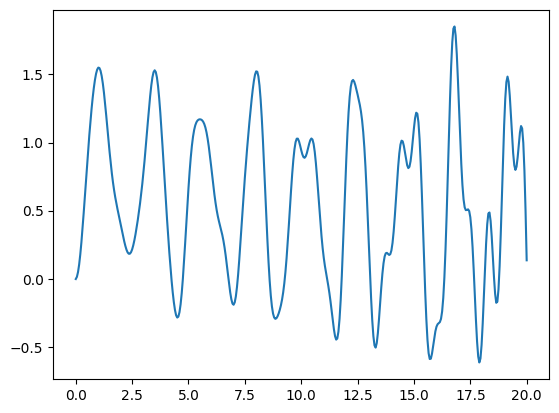

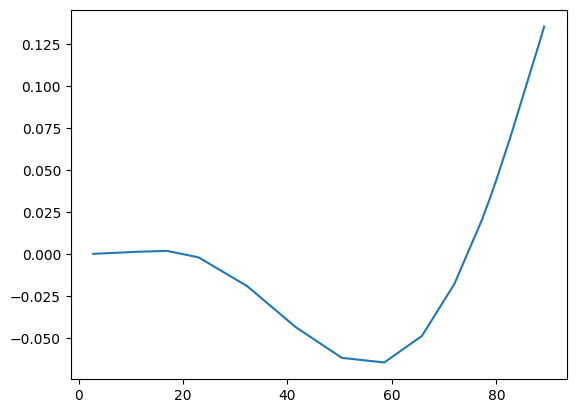

MovieWriter ffmpeg unavailable; using Pillow instead.


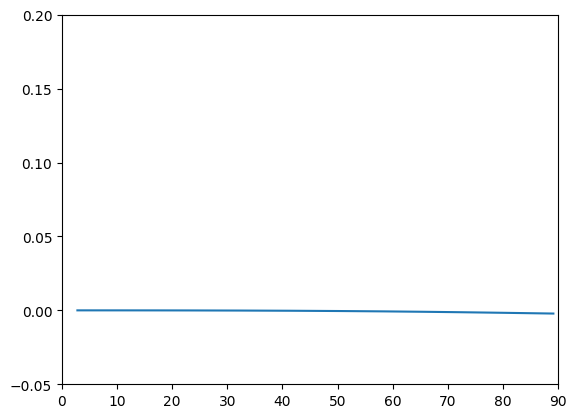

In [24]:
print(solu.keys(), solu['time'].shape, solu['x_array'].shape)
print(solu['u_array'].shape)

plt.figure()
plt.plot(solu['time'], solu['u_array'][:,0,-1,0])
plt.show()

plt.figure()
plt.plot(r_array, solu['u_array'][-1,0,:,0])
plt.show()


fig, ax = plt.subplots()
line = ax.plot(r_array, solu['u_array'][0,0,:,0])[0]
ax.set(xlim=[0, 90], ylim=[-0.05, 0.2])

def update(frame):
    line.set_xdata(r_array)
    line.set_ydata(solu['u_array'][frame,0,:,0])
    return line

ani = animation.FuncAnimation(fig=fig, func=update, frames=len(solu['u_array'][:,0,0,0]), interval=50)
ani.save("anim.gif")